[np.float64(38.0), np.float64(230.0), np.float64(236.0), np.float64(232.0)]


/var/folders/y5/yhh2lj4d5pqfmj880n0dd8180000gn/T/ipykernel_77022/1094314565.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('turbo', 10)


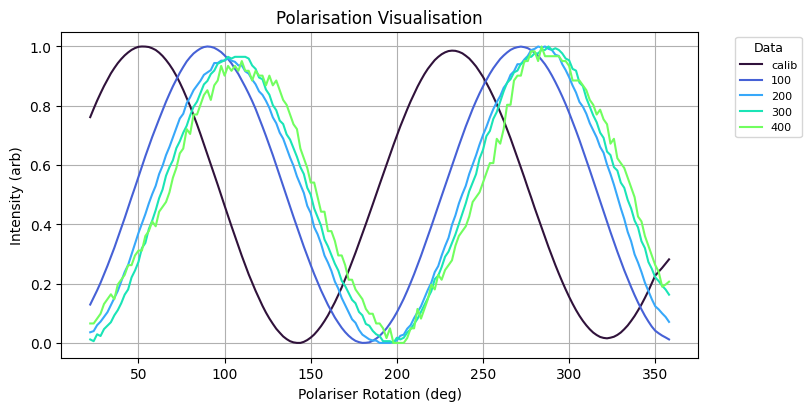

specific rotation: 345.8823529411765 deg dm^-1 g/mL^-1


np.float64(0.5880000000000001)

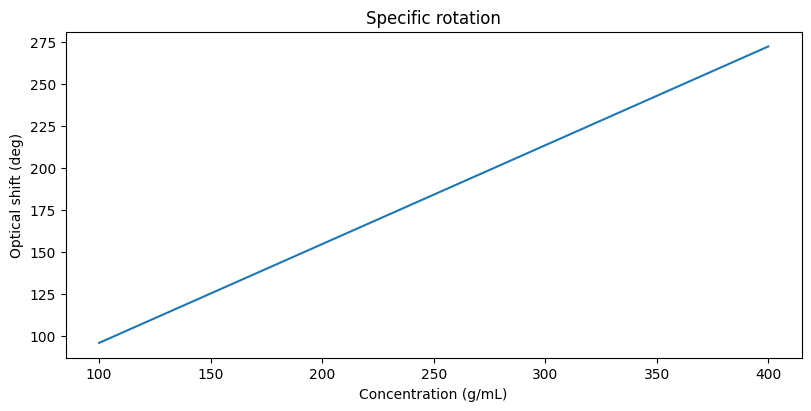

In [35]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.signal import correlate
import numpy as np

def calculate_shift(angle_rad, inten, ref_angle, ref_inten):
    """
    Compute the angular shift of inten relative to ref_inten
    using cross-correlation.
    
    Returns shift in degrees.
    """
    # Make sure both arrays are normalized and equally spaced
    ys = (inten - np.min(inten)) / (np.max(inten) - np.min(inten))
    ref_ys = (ref_inten - np.min(ref_inten)) / (np.max(ref_inten) - np.min(ref_inten))
    
    # Interpolate to same number of points if needed
    n = max(len(ys), len(ref_ys))
    ys_interp = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(ys)), ys)
    ref_interp = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(ref_ys)), ref_ys)
    
    # Compute cross-correlation
    corr = correlate(ys_interp, ref_interp, mode='full')
    lag_idx = np.argmax(corr)  # index of max correlation
    lag = lag_idx - (n - 1)  # shift in points
    
    # Convert lag to degrees
    delta_angle = lag * (angle_rad[1] - angle_rad[0]) * (180 / np.pi)
    return delta_angle

def read_data(path):
    df = pd.read_csv(path, comment='#')
    #df = pd.read_csv('../dat/GREEN/808nm_calib.csv', comment='#')
    # err data angles
    
    angle_deg = df.iloc[:, 0].values
    angle_rad = np.deg2rad(angle_deg)  # 0 to pi
    
    intensities = df.iloc[:, 1:].values
    intensities_rad = intensities.T

    return angle_rad, intensities_rad

def movav(y, window_size=9):
    return np.convolve(y, np.ones(window_size)/window_size, mode='same')

def movav2(y, window_size=9):
    """Centered moving average using pandas to avoid edge shrinking."""
    y_series = pd.Series(y)
    ys_smooth = y_series.rolling(window=window_size, center=True, min_periods=1).mean()
    return ys_smooth.to_numpy()

def do_plot_normal(angle_rad, intensities_rad, fix, ax, cmap, title, offset = False):
    global RAND_INDEX
    intensities_rad = intensities_rad / np.nanmax(intensities_rad)

    i = 0
    for y_intensity in intensities_rad:
        angl = math.pi * (1.0/180.0) * float(i) * 10.0
        inten = (y_intensity / 1.0) #/ np.nanmax(y_intensity))
        xs = angle_rad * (180.0 / math.pi)
        ys = inten   
        if offset:
            max_idx = np.argmax(ys)
            ys_rot = np.roll(ys, -max_idx)
            xs_shifted = (xs - xs[max_idx]) % 180
            sorted_idx = np.argsort(xs_shifted)
            xs = xs_shifted[sorted_idx]
            ys = ys_rot[sorted_idx]
        ys = movav(ys)
        ax.plot(xs, ys, label = title + " sub " +str(i*10), color=cmap(RAND_INDEX))
        RAND_INDEX = RAND_INDEX + 1   
        i = i + 1

def do_plot_concen(angle_rad, inten, fix, ax, cmap, title, gL):
    global RAND_INDEX
    global DIF_FROM_MAX
    
    xs = angle_rad * (180.0 / math.pi)
    
    # Normalize before smoothing
    i_min = np.min(inten)
    i_max = np.max(inten)
    ys = (inten - i_min) / (i_max - i_min)
    
    # Then smooth
    ys = movav2(ys)
    
    xs = xs[10:]
    ys = ys[10:]

    i_min = np.min(ys)
    i_max = np.max(ys)
    ys = (ys - i_min) / (i_max - i_min)
    
    ax.plot(xs, ys, label=title, color=cmap(RAND_INDEX))
    
    DIF_FROM_MAX.append([xs[np.nanargmax(ys)], gL])
    RAND_INDEX += 1 

def plot_concens(PATH_LEN, folder, names):
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    cmap = plt.cm.get_cmap('turbo', 10)
    ax.set(
        xlabel='Polariser Rotation (deg)',
        ylabel='Intensity (arb)',
        title='Polarisation Visualisation'
    )
    for n in names:
        angle_rad, i_rad = read_data("/users/lucas/desktop/physics/year 3/project 1/dat/" + folder + n[0] + ".csv")
        i_rad = i_rad[0]
        do_plot_concen(angle_rad, i_rad, fig, ax, cmap, n[0], n[1])
    xs = []
    ys = []
    for i in range(1, len(DIF_FROM_MAX)):
        shift_deg = np.abs((DIF_FROM_MAX[i][0] - DIF_FROM_MAX[0][0]))
        xs.append(float(DIF_FROM_MAX[i][1])) # concentration in g/mL
        ys.append(shift_deg) # shift in deg
    print(ys)
    ax.grid(True)
    ax.legend(
        title="Data",
        bbox_to_anchor=(1.05, 1), loc='upper left',
        fontsize=8, title_fontsize=9
    )
    plt.show()
    return np.array(xs), np.array(ys)

# path length in dm
PATH_LEN = 17e-1
RAND_INDEX = 0
DIF_FROM_MAX = []

#xs1, ys1 = plot_concens(PATH_LEN, "sugar4/R/", [["calib", 0], ["100", 100], ["200", 200], ["300", 300], ["400", 400], ["600", 600], ["700", 700], ["800", 800], ["900", 900], ["1000",1000]])
#xs1, ys1 = plot_concens(PATH_LEN, "sugar4/G/", [["calib", 0], ["100", 100], ["200", 200], ["300", 300], ["400", 400], ["600", 600], ["700", 700], ["800", 800], ["900", 900], ["1000",1000]])
xs1, ys1 = plot_concens(PATH_LEN, "sugar4/B/", [["calib", 0], ["100", 100], ["200", 200], ["300", 300], ["400", 400]])
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(np.unique(xs1), np.poly1d(np.polyfit(xs1, ys1, 1))(np.unique(xs1)))
ax.set(xlabel="Concentration (g/mL)", ylabel="Optical shift (deg)",title="Specific rotation")

slope = np.polyfit(xs1, ys1, 1)[0]
print("specific rotation: " + str(slope / PATH_LEN * 1000) + " deg dm^-1 g/mL^-1") # 1.7dm
